<a href="https://colab.research.google.com/github/FadulSaif/AD_Prediction_SVM/blob/main/SVM_Fadul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Data Cleaning of the oasis dataset.



In [3]:
from google.colab import drive, files
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/oasis_cross-sectional.csv')
print('CSV file uploaded')

Mounted at /content/drive
CSV file uploaded


In [4]:
print(df.isnull().sum())


ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64


In [5]:
df = df.drop(columns=["ID", "Delay", "Hand"], errors="ignore")  # `errors="ignore"` prevents errors if columns don't exist

In [6]:
# Columns with missing values
columns_to_impute = ["Educ", "SES", "MMSE", "CDR"]

# Initialize the imputer (median strategy)
imputer = SimpleImputer(strategy="median")

# Fill missing values
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [7]:
# Handle CDR values of 3 by changing them to 2
df['CDR'] = df['CDR'].replace(3.0, 2.0)

In [8]:
# Convert CDR to string labels for classification
df['CDR'] = df['CDR'].astype(str)

# Optional: Verify the data type
print("\nData type of CDR after converting to category:")
print(df['CDR'].dtype)


Data type of CDR after converting to category:
object


In [9]:
print(df.isnull().sum())
print(df.columns.tolist())

M/F     0
Age     0
Educ    0
SES     0
MMSE    0
CDR     0
eTIV    0
nWBV    0
ASF     0
dtype: int64
['M/F', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']


In [10]:
# Preprocess string values (e.g., strip whitespace, convert to upper case)
df['M/F'] = df['M/F'].astype(str).str.strip().str.upper()

# Count unexpected values before mapping
unexpected = df[~df['M/F'].isin(['F', 'M'])]
print(f"Found {len(unexpected)} unexpected gender values:\n", unexpected['M/F'].value_counts())

# Map known values to 0/1, others become NaN
df['M/F'] = df['M/F'].map({'F': 0, 'M': 1})

# Impute missing with most frequent value
mf_imputer = SimpleImputer(strategy='most_frequent')
df['M/F'] = mf_imputer.fit_transform(df[['M/F']])

# Report
print(df['M/F'].value_counts())
print("Missing values after imputation:", df['M/F'].isnull().sum())


Found 0 unexpected gender values:
 Series([], Name: count, dtype: int64)
M/F
0    268
1    168
Name: count, dtype: int64
Missing values after imputation: 0


In [11]:
print(df.isnull().sum())


M/F     0
Age     0
Educ    0
SES     0
MMSE    0
CDR     0
eTIV    0
nWBV    0
ASF     0
dtype: int64


In [12]:
# Features (X): All columns EXCEPT 'CDR'
X = df.drop("CDR", axis=1)

# Target (y): Only the 'CDR' column
y = df["CDR"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (436, 8)
y shape: (436,)


In [13]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (348, 8) (348,)
Test shapes: (88, 8) (88,)


In [14]:
# Columns to scale (numerical features only)
numeric_cols = ["Age", "Educ", "SES", "MMSE", "eTIV", "nWBV", "ASF"]

# Initialize scaler (fit only on training data)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])  # Use same scaling for test

In [15]:
# Separate features and target variable
X = df.drop('CDR', axis=1)
y = df['CDR']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for better readability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Verify scaling
print(X_scaled.describe().loc[['mean', 'std']])

               M/F           Age          Educ           SES          MMSE  \
mean -3.259370e-17 -5.092766e-17 -2.363044e-16 -2.159333e-16 -6.111319e-16   
std   1.001149e+00  1.001149e+00  1.001149e+00  1.001149e+00  1.001149e+00   

              eTIV          nWBV           ASF  
mean -2.088034e-16 -7.741005e-16  2.127758e-15  
std   1.001149e+00  1.001149e+00  1.001149e+00  


SVM Training

In [16]:
svc_model = SVC(random_state=42)
print("Training the SVC model...")
svc_model.fit(X_train, y_train)
print("Model training complete.")

Training the SVC model...
Model training complete.


In [17]:
# Make predictions on the test data
print("Making predictions on the test data...")
svc_predictions = svc_model.predict(X_test)
print("Predictions complete.")

Making predictions on the test data...
Predictions complete.


In [18]:
y_train.value_counts()

,count
CDR,
0.0,267
0.5,59
1.0,21
2.0,1


In [19]:
# Evaluate the model
print("\nSVC Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, svc_predictions))
print("\nClassification Report:\n", classification_report(y_test, svc_predictions))


SVC Model Evaluation:
Accuracy: 0.8068181818181818

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.97      0.93        69
         0.5       0.33      0.36      0.35        11
         1.0       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00         1

    accuracy                           0.81        88
   macro avg       0.31      0.33      0.32        88
weighted avg       0.74      0.81      0.77        88



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


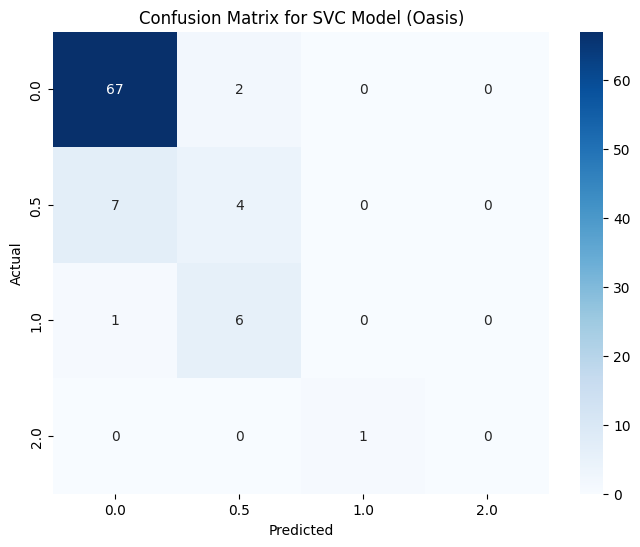


Confusion Matrix:
[[67  2  0  0]
 [ 7  4  0  0]
 [ 1  6  0  0]
 [ 0  0  1  0]]


In [20]:
# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, svc_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svc_model.classes_, yticklabels=svc_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVC Model (Oasis)')
plt.show()

print("\nConfusion Matrix:")
print(cm)

Experiment 1: Kernel Type

In [21]:
param_grid_1 = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

svc1 = SVC()
grid1 = GridSearchCV(svc1, param_grid_1, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid1.fit(X_train, y_train)

# Evaluation
print("Best Kernel:", grid1.best_params_)
y_pred1 = grid1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))
print("Classification Report:\n", classification_report(y_test, y_pred1))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Kernel: {'kernel': 'linear'}
Accuracy: 0.7954545454545454
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.96      0.92        69
         0.5       0.31      0.36      0.33        11
         1.0       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00         1

    accuracy                           0.80        88
   macro avg       0.30      0.33      0.31        88
weighted avg       0.74      0.80      0.77        88



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment 2: Tuning C and gamma

In [22]:
param_grid_2 = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

svc2 = SVC(kernel='rbf')
grid2 = GridSearchCV(svc2, param_grid_2, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid2.fit(X_train, y_train)

print("Best Params:", grid2.best_params_)
y_pred2 = grid2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred2))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Params: {'C': 10, 'gamma': 'scale'}
Accuracy: 0.8295454545454546
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94        69
         0.5       0.43      0.55      0.48        11
         1.0       0.50      0.14      0.22         7
         2.0       0.00      0.00      0.00         1

    accuracy                           0.83        88
   macro avg       0.46      0.41      0.41        88
weighted avg       0.81      0.83      0.81        88



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment 3: Tuning degree for Polynomial Kernel

In [23]:
param_grid_3 = {
    'degree': [2, 3, 4, 5],
    'C': [1, 10]
}

svc3 = SVC(kernel='poly')
grid3 = GridSearchCV(svc3, param_grid_3, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid3.fit(X_train, y_train)

print("Best Params:", grid3.best_params_)
y_pred3 = grid3.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred3))
print("Classification Report:\n", classification_report(y_test, y_pred3))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Params: {'C': 10, 'degree': 3}
Accuracy: 0.7954545454545454
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.96      0.92        69
         0.5       0.27      0.27      0.27        11
         1.0       0.50      0.14      0.22         7
         2.0       0.00      0.00      0.00         1

    accuracy                           0.80        88
   macro avg       0.41      0.34      0.35        88
weighted avg       0.76      0.80      0.77        88



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment 4: Combined Grid Search

In [24]:
param_grid_4 = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

svc4 = SVC()
grid4 = GridSearchCV(svc4, param_grid_4, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid4.fit(X_train, y_train)

print("Best Params:", grid4.best_params_)
y_pred4 = grid4.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print("Classification Report:\n", classification_report(y_test, y_pred4))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.7840909090909091
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.94      0.92        69
         0.5       0.29      0.36      0.32        11
         1.0       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00         1

    accuracy                           0.78        88
   macro avg       0.29      0.33      0.31        88
weighted avg       0.73      0.78      0.76        88



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
print("Best Kernel:", grid1.best_params_)
print("Best Params:", grid2.best_params_)
print("Best Params:", grid3.best_params_)
print("Best Params:", grid4.best_params_)

Best Kernel: {'kernel': 'linear'}
Best Params: {'C': 10, 'gamma': 'scale'}
Best Params: {'C': 10, 'degree': 3}
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
